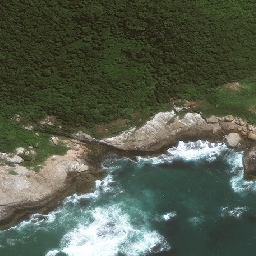

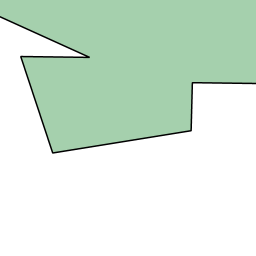

In [4]:
import cv2
import numpy as np
import os

from PIL import Image
from IPython.display import display

im = Image.open('n41p6948722325_n22p4055718965_n41p6928167264_n22p4028294504_raw.png')
gt= Image.open('n41p6948722325_n22p4055718965_n41p6928167264_n22p4028294504_gt.png')
ima = np.asarray(im, dtype=np.uint8)
gta = np.load('n41p6948722325_n22p4055718965_n41p6928167264_n22p4028294504.npy')
display (im)
display (gt)

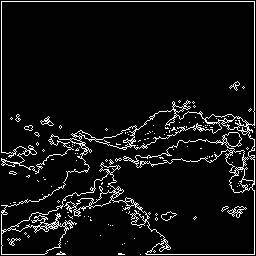

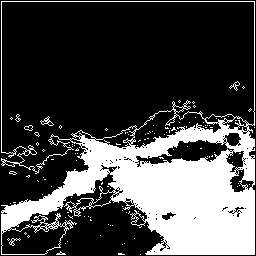

In [5]:
img = cv2.imread('n41p6948722325_n22p4055718965_n41p6928167264_n22p4028294504_raw.png',0)
ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#np.histogram(thresh)
#imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#ret,thresh = cv2.threshold(img,0,255,0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
cimt = np.ones((256,256),dtype=np.uint8)
cv2.drawContours(cimt,contours,-1,255,1)
areas = [cv2.contourArea(cnt) for cnt in contours ]
display (Image.fromarray(cimt))
h = np.mean(areas)
np.std(areas)
mask = np.zeros((258,258), np.uint8)
cv2.floodFill(cimt,mask,(250,250),255,0,255)
display (Image.fromarray(cimt))

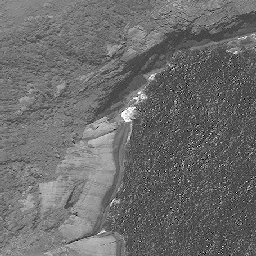

In [6]:
im = Image.open('n41p940975909_n22p8723511097_n41p9389283747_n22p8696087029_raw.png')
display (im)
ima = cv2.imread('n41p940975909_n22p8723511097_n41p9389283747_n22p8696087029_raw.png',0)
gta = np.load('n41p940975909_n22p8723511097_n41p9389283747_n22p8696087029.npy')

In [7]:
rows = [i for i in xrange(gta.shape[0]) if sum(gta[i,:])==gta.shape[1]]
cols = [i for i in xrange(gta.shape[1]) if sum(gta[:,i])==gta.shape[0]]
mask = np.zeros(gta.shape)
mask[rows,:] = 255
mask[:,cols] = 255
mask

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

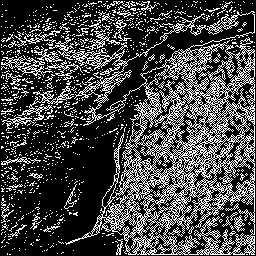

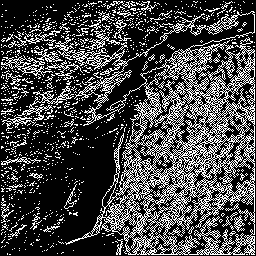

In [8]:
ret, thresh = cv2.threshold(ima,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#np.histogram(thresh)
#imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#ret,thresh = cv2.threshold(img,0,255,0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
cimt = np.ones((256,256),dtype=np.uint8)
cv2.drawContours(cimt,contours,-1,255,1)
display (Image.fromarray(cimt))
mask = np.zeros((258,258), np.uint8)
cv2.floodFill(cimt,mask,(250,250),255,0,255)
display (Image.fromarray(cimt))

In [75]:
from scipy.ndimage.morphology import distance_transform_edt
from numpy.random import choice
import itertools

m1 = distance_transform_edt(gta)
#m1 = m1 / np.max(m1)

gta2 = np.copy(gta)
gta2[gta==0]=1
gta2[gta==1]=0
gta2
m2 = distance_transform_edt(gta2)
#m2 = m2 / np.max(m2)
#w = m1 + m2

positions = zip(*np.where(m2>10))
values = [m2[x[0],x[1]] for x in positions]
probs = values/np.sum(values)
landCoors  = [positions[x] for x in choice(len(positions),10,False, probs)]

positions = zip(*np.where(m1>2))
values = [m1[x[0],x[1]] for x in positions]
probs = values/np.sum(values)
waterCoors  = [positions[x] for x in choice(len(positions),10,False, probs)]

#probsLand = np.float64(m2).ravel()
#probsLand /= np.sum(probsLand)
#winners = choice(len(probsLand), 10, False, probs)

#resultLand = np.zeros(m1.shape, np.uint8)
#resultLand.ravel()[winners] = 1
#landCoors =  zip(*np.where(resultLand>0))

#probsWater= np.float64(m1).ravel()
#probsWater /= np.sum(probsWater)
#winners = choice(len(probsWater), 10, False, probs)

#resultWater = np.zeros(m1.shape, np.uint8)
#resultWater.ravel()[winners] = 1
#print np.where(resultWater>0)
#waterCoors =  zip(*np.where(resultWater>0))

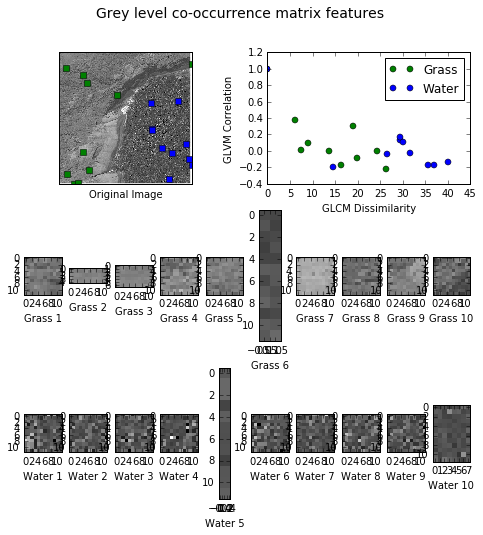

In [76]:

%matplotlib inline
from skimage.feature import greycomatrix, greycoprops
from skimage import data
import matplotlib.pyplot as plt
import random

PATCH_SIZE = 12
grass_locations = list()
grass_patches = []
water_locations = list()
water_patches = []

for wc in waterCoors:
    water_patches.append(ima[wc[0]:wc[0]+PATCH_SIZE,wc[1]:wc[1]+PATCH_SIZE])  
    water_locations.append(wc)
    
for lc in landCoors:
    grass_patches.append(ima[lc[0]:lc[0]+PATCH_SIZE,lc[1]:lc[1]+PATCH_SIZE])  
    grass_locations.append(lc)
  
xs = []
ys = []
for patch in (grass_patches + water_patches):
    glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])
    
    
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(ima, cmap=plt.cm.gray, interpolation='nearest',
          vmin=0, vmax=255)
for (y, x) in grass_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in water_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(grass_patches)], ys[:len(grass_patches)], 'go',
        label='Grass')
ax.plot(xs[len(grass_patches):], ys[len(grass_patches):], 'bo',
        label='Water')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLVM Correlation')
ax.legend()

for i, patch in enumerate(grass_patches):
    ax = fig.add_subplot(3, len(grass_patches), len(grass_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('Grass %d' % (i + 1))

for i, patch in enumerate(water_patches):
    ax = fig.add_subplot(3, len(water_patches), len(water_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('Water %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14)
plt.show()



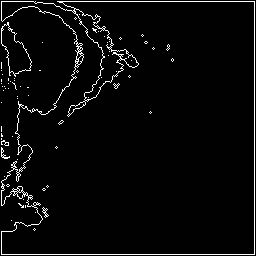

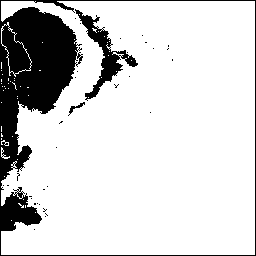

In [29]:
img = cv2.imread('n41p7129455526_n22p422088963_n41p7108906306_n22p4193465198_raw.png',0)
ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#np.histogram(thresh)
#imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#ret,thresh = cv2.threshold(img,0,255,0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
cimt = np.ones((256,256),dtype=np.uint8)
cv2.drawContours(cimt,contours,-1,255,1)
display (Image.fromarray(cimt))
mask = np.zeros((258,258), np.uint8)
cv2.floodFill(cimt,mask,(250,250),255,0,255)
display (Image.fromarray(cimt))

Rotated images matched against references using Gabor filter banks:
original: grass, rotated: 145deg, match result: water


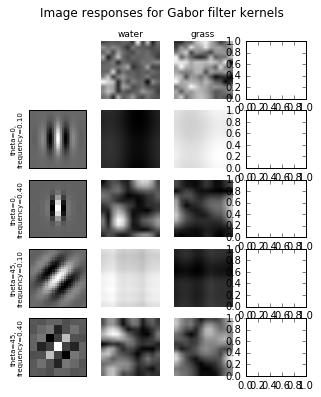

In [77]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel


def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i


# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)


shrink = (slice(0, None, 3), slice(0, None, 3))
water = water_patches[0]
grass = grass_patches[0]
image_names = ('water', 'grass')
images = (water, grass, )

# prepare reference features
ref_feats = np.zeros((2, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats(water, kernels)
ref_feats[1, :, :] = compute_feats(grass, kernels)

print('Rotated images matched against references using Gabor filter banks:')

print('original: grass, rotated: 145deg, match result: ', end='')
feats = compute_feats(ndi.rotate(grass, angle=145, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])


def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(5, 6))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel), interpolation='nearest')
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()